<a href="https://colab.research.google.com/github/imyoungchae/Tensorflow_study/blob/main/tensorflow5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN (Convolution Neural Network)을 활용한 이미지 분류(Image Classification)

# Import

In [ ]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Load Dataset

Load Dataset

가위바이보에 대한 사진을 가지고 가위인지, 바위인지, 보자기인지 classification

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

# ImageDataGenrator

ImageDataCenerator
전처리

In [ ]:
TRAINING_DIR = "tmp/rps/"

ImageDataGenerator를 정리
- rescale: 이미지의 픽셀 값을 조정
- rotation_range: 이미지 회전
- width_shift_range: 가로 방향으로 이동
- height_shift_range: 세로 방향으로 이동
- shear_range: 이미지 굴절
- zoom_range: 이미지 확대
- horizontal_filp: 횡 방향으로 이미지 반전
- fill_mode: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
- validation_split: validation set의 구성 비율

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    # 위의 옵션 값들을 보고 적절히 대입하여 준다.
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.2
    )

ImageDataGenerator를 잘 만들어 주었다면 
flow_from_directory로 이미지를 어떻게 공급할 것인가를 지정해주어야 함
- train/validation set 전용 generator를 별도로 정의
- batch_size를 정의(128)
- target_size를 정의(150*150), 이미지를 알아서 타겟 사이즈만큼 잘라내어 공급함
- class_mode는 3개 이상의 클래스인 경우 'categorical', 이진 분류의 경우 'binary'를 지정
- subset을 지정(training/validation)

training_generator에 대한 from_from_directory를 정의
- 2016개의 이미지가 출력되어야 함

In [ ]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=32, 
                                                          target_size=(150, 150), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 2016 images belonging to 3 classes.


validation_generator에 대한 from_from_directory를 정의
- 504개의 이미지가 출력되어야 함

In [ ]:
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                            batch_size=32, 
                                                            target_size=(150, 150), 
                                                            class_mode='categorical',
                                                            subset='validation', 
                                                            )

Found 504 images belonging to 3 classes.


# 시각화 해보기

오리지널 사진 파일
Found 2520 images belonging to 3 classes.
(128, 150, 150, 3) (128, 3)
[1. 0. 0.]


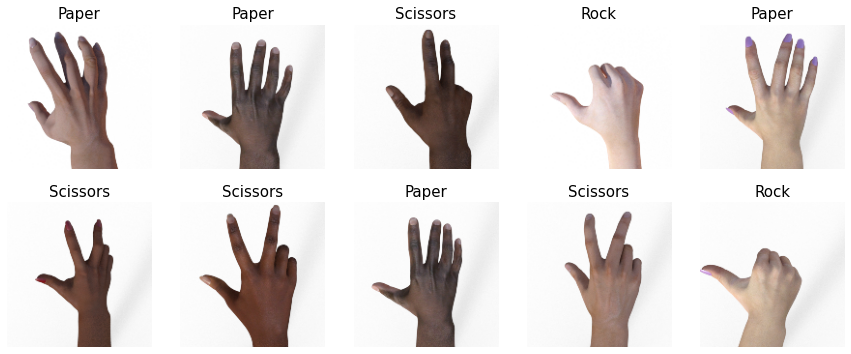

Augmentation 적용한 사진 파일
(32, 150, 150, 3) (32, 3)
[1. 0. 0.]


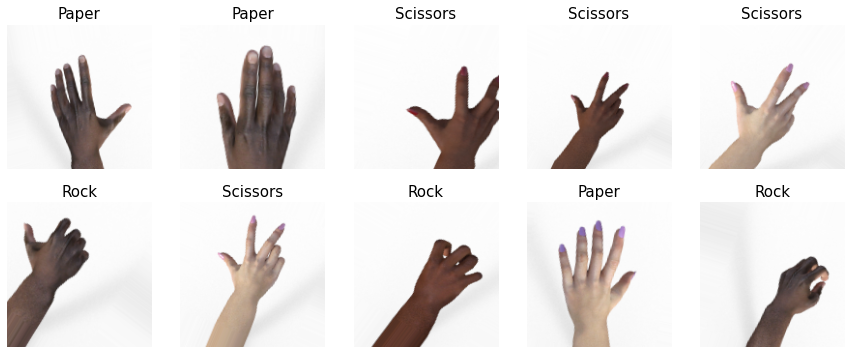

In [ ]:
import matplotlib.pyplot as plt

class_map = {
    0: 'Paper',
    1: 'Rock', 
    2: 'Scissors'
}

print('오리지널 사진 파일')

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(150, 150), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    plt.show()
    break
    
print('Augmentation 적용한 사진 파일')
    
for x, y in training_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    
    plt.show()
    break

# CNN(Convolution Neural Network)
- CNN-activation-pooling 과정을 통해 이미지 부분의 주요한 Feature들을 추출해준다
- CNN을 통해 우리는 다양한 1개의 이미지를 filter를 거친 다수의 이미지로 출력한다
- filter의 사이즈는 3*3 필터를 자주 사용

# Conv2D 이미지 특성 추출

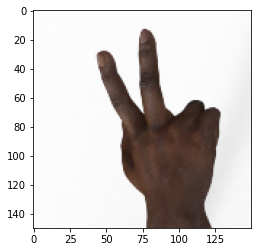

In [ ]:
for x, y in original_generator:
    pic = x[:5]
    break
    
plt.imshow(pic[0])

In [ ]:
conv2d = Conv2D(64, (3, 3), input_shape=(150, 150, 3))
conv2d_activation = Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3))

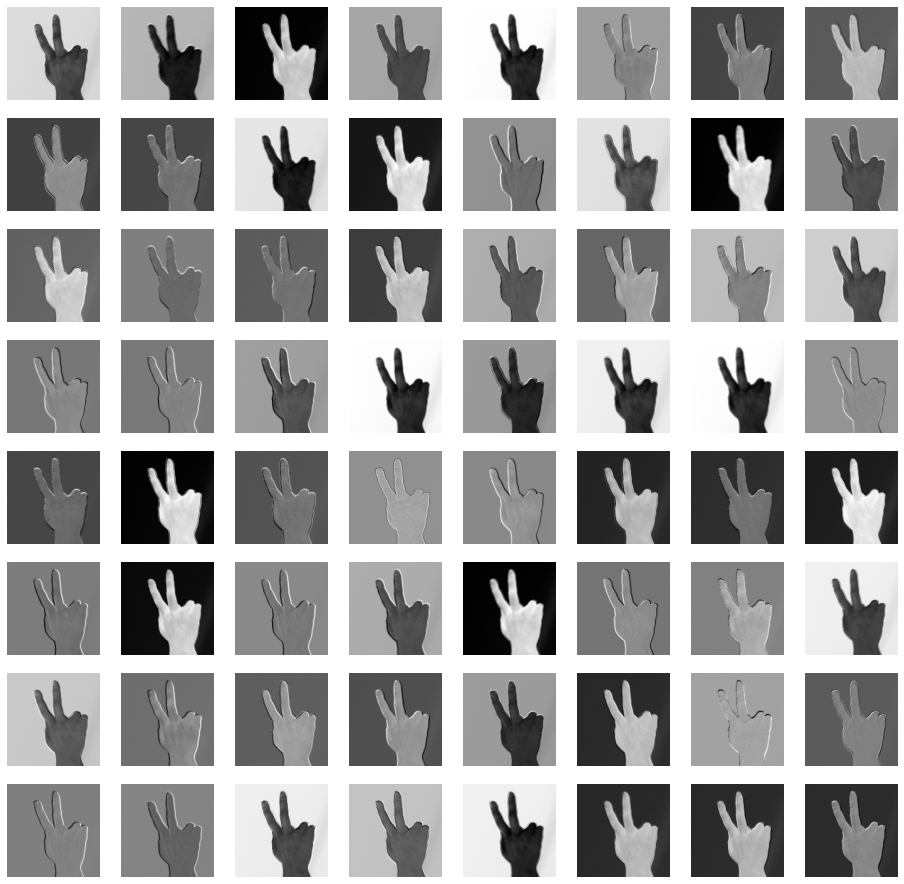

In [ ]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16, 16)
for i in range(64):
    axes[i//8, i%8].imshow(conv2d(pic)[0,:,:,i], cmap='gray')
    axes[i//8, i%8].axis('off')

# MaxPooling2D 이미지 특성 추출

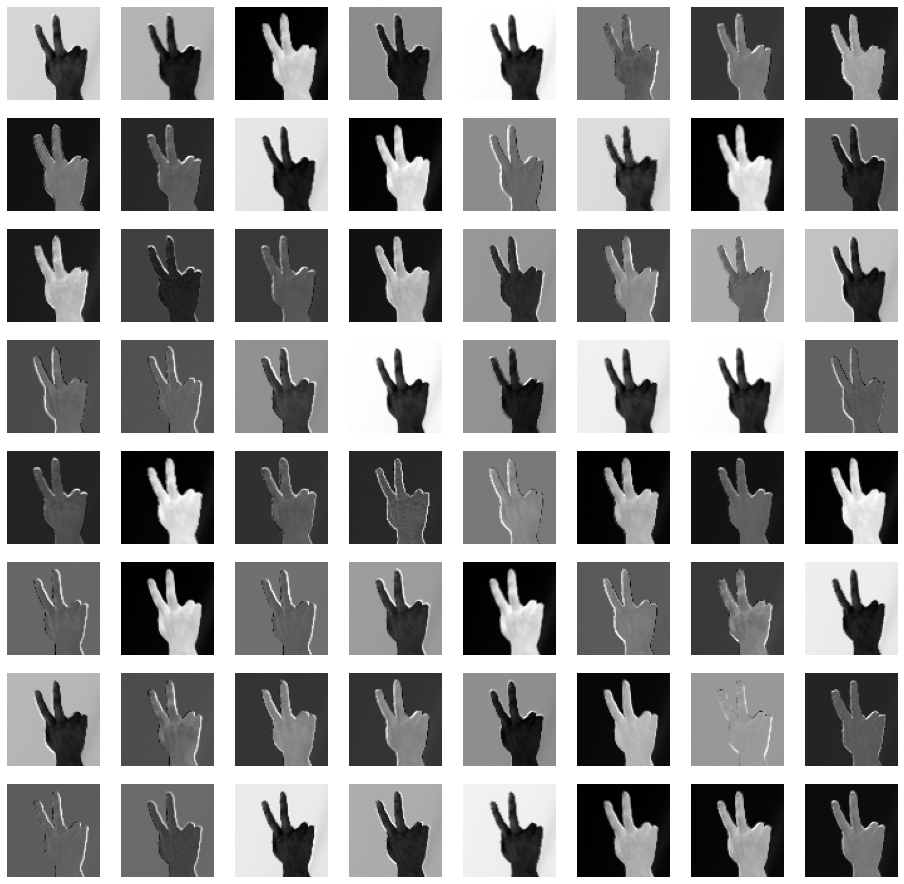

In [ ]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16, 16)
for i in range(64):
    axes[i//8, i%8].imshow(MaxPooling2D(2, 2)(conv2d(pic))[0, :, :, i], cmap='gray')
    axes[i//8, i%8].axis('off')

# 단계별 특성 추출 과정

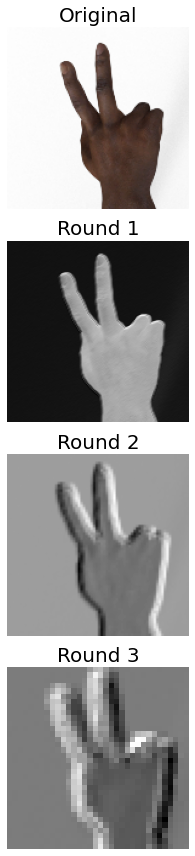

In [ ]:
conv1 = Conv2D(64, (3, 3), input_shape=(150, 150, 3))(pic)
max1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(64, (3, 3))(max1)
max2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, (3, 3))(max2)
max3 = MaxPooling2D(2, 2)(conv3)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6, 12)
axes[0].set_title('Original', fontsize=20)
axes[0].imshow(pic[0])
axes[0].axis('off')
axes[1].set_title('Round 1', fontsize=20)
axes[1].imshow( conv1[0, :, :, 0], cmap='gray')
axes[1].axis('off')
axes[2].set_title('Round 2', fontsize=20)
axes[2].imshow( conv2[0, :, :, 0], cmap='gray')
axes[2].axis('off')
axes[3].set_title('Round 3', fontsize=20)
axes[3].imshow( conv3[0, :, :, 0], cmap='gray')
axes[3].axis('off')
plt.tight_layout()
plt.show()

# Sequential

In [ ]:
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓음. 첫번째 입력층의 input_shape은 (150, 150, 3)으로 지정
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),# 필터의 갯수 64
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 

    # 2D -> 1D로 변환을 위하여 Flatten(필수!)
    Flatten(), 
    # 과적합 방지를 위하여 Dropout을 적용
    Dropout(0.5),
    Dense(512, activation='relu'),
    # Dense


    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (3개), activation도 잊지말기
    Dense(3, activation='softmax'),
])

In [ ]:
model.summary()
#150*150이였는데 2픽셀씩 빠져서 148*148

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 17, 17, 128)      0

# compile

- optimizer는 최적화가 잘되는 알고리즘인 'adam'사용
- loss 설정
  - 출력층 activation이 sigmoid인 경우: binart_crossentropy
  * 출력층 activation이 softmax 인 경우: 
    * 원핫인코딩(O): categorical_crossentropy
    * 원핫인코딩(X): sparse_categorical_crossentropy
- 참고: ImageDataGenerator는 자동으로 Lable을 원핫인코딩 해준다
- metrics를 'acc' 혹은 'accuracy'로 지정하면 학습시 정확도를 모니터링 할 수 있음

In [ ]:
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# ModelCheckpoint

val_loss를 기준으로 epoch마다 최적의 모델을 저장하기 위하여 ModelCheckpoint를 만든다
- checkpoint_path는 모델이 저장될 파일 명을 설정
- ModelCheckpoint를 선언하고 적절한 옵션 값을 지정

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

# Fit

In [ ]:
epochs=25

In [ ]:
model.fit(training_generator, 
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint],
          )

Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 1.0975 - acc: 0.3581
Epoch 1: val_loss improved from inf to 1.03389, saving model to tmp_checkpoint.ckpt
63/63 [==============================] - 173s 3s/step - loss: 1.0975 - acc: 0.3581 - val_loss: 1.0339 - val_acc: 0.5496
Epoch 2/25
63/63 [==============================] - ETA: 0s - loss: 0.7478 - acc: 0.6696
Epoch 2: val_loss improved from 1.03389 to 0.86093, saving model to tmp_checkpoint.ckpt
63/63 [==============================] - 163s 3s/step - loss: 0.7478 - acc: 0.6696 - val_loss: 0.8609 - val_acc: 0.5575
Epoch 3/25
63/63 [==============================] - ETA: 0s - loss: 0.3405 - acc: 0.8626
Epoch 3: val_loss improved from 0.86093 to 0.62440, saving model to tmp_checkpoint.ckpt
63/63 [==============================] - 163s 3s/step - loss: 0.3405 - acc: 0.8626 - val_loss: 0.6244 - val_acc: 0.7679
Epoch 4/25
63/63 [==============================] - ETA: 0s - loss: 0.2794 - acc: 0.9013
Epoch 4: val_loss improv

# 학습 완료 후 Load Weights(ModelCheckpoint)


학습이 완료된 후에는 반드시 load_weights 해주어야 한다

In [ ]:
model.load_weights(checkpoint_path)